In [313]:
# Data collected on Jan 23, 2023

In [314]:
"""
STATE: AL
POLICY: Geriatric Parole
VERSION: V1
DATA SOURCE: Public AL reports
DATA QUALITY: medium-low
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: October 2022
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 3600x2100 with 0 Axes>

# AGE

In [315]:
# DOC Jan 2023 Monthly report
doc_age = pd.read_csv("./data/AL Prison_Parole Raw Data - DOC age dist.csv")

In [316]:
doc_age["percent"] = doc_age["Jurisdictional %"].str.rstrip("%").astype("float") / 100.0
age = doc_age.set_index("Age").percent
pd.DataFrame(age).T

Age,Age 15,Age 16,Age 17,Age 18,Age 19,Age 20,Ages 21-25,Ages 26-30,Ages 31-35,Ages 36-40,Ages 41-45,Ages 46-50,Ages 51-60,Ages 60+
percent,0.0,0.0,0.0,0.0,0.001,0.003,0.048,0.104,0.149,0.156,0.153,0.117,0.172,0.096


In [317]:
age_eligible_proportion = (
    age["Ages 60+"] + age["Ages 51-60"] + (1 / 5 * age["Ages 46-50"])
)
age_eligible_proportion

0.2914

In [318]:
age_eligible_within_five_years = (age["Ages 46-50"] * 4 / 5) + (
    age["Ages 41-45"] * 1 / 5
)
age_eligible_within_five_years

0.12419999999999999

# LOS

In [319]:
doc_los = pd.read_csv(
    "./data/AL Prison_Parole Raw Data - DOC Length of stay dist geriatric.csv",
    thousands=",",
)
doc_los["Percent"] = doc_los["Percent"].str.rstrip("%").astype("float") / 100.0
eligible_sentences = doc_los[
    (doc_los.sen_length_for_geriatric >= 20)  # only take sentences 20+ years
    & (
        doc_los.sen_length_for_geriatric < 100
    )  # exclude death row, life without/barred parole
].copy()
eligible_sentences

,Sentence Length,Total,Percent,sen_length_for_geriatric
8,20 yrs,4470,0.169,20.0
9,From 20 to 25 yrs,605,0.023,20.0
10,25 yrs,1412,0.053,25.0
11,From 25 to 35 yrs,1320,0.050,25.0
12,Over 35 yrs,1236,0.047,70.0
13,Life,3651,0.138,75.0


In [320]:
eligible_sentences_proportion = eligible_sentences.Percent.sum()

# PROPORTION OF GERIATRIC ELIGIBLE MODELING

In [321]:
# DOC Jan 2023 Monthly report - CUSTODY POPULATION
prison_pop = 20608

In [322]:
# % currently eligible for geriatric parole
eligible_sentences_proportion * age_eligible_proportion * 100

13.9872

### --------------

In [323]:
geriatric_eligible = (
    prison_pop * eligible_sentences_proportion * age_eligible_proportion
)
int(geriatric_eligible)

2882

### --------------

In [324]:
eligible_with_five = (
    prison_pop * eligible_sentences_proportion * age_eligible_within_five_years
)
int(eligible_with_five)

1228

In [325]:
def calc_parole(time_df, starting_pop, grant_rate, hearing_window):
    df = time_df.copy()
    granted = starting_pop * grant_rate
    granted_per_month = granted / hearing_window

    df["starting_pop"] = starting_pop
    df["months"] = df.index
    df["releases"] = granted_per_month * df.months

    df["pop"] = np.where(
        df.months <= hearing_window, df.starting_pop - df.releases, np.nan
    )
    df["pop"].fillna(method="ffill", inplace=True)
    return df[["pop"]]

In [326]:
one_year_window = 12
five_year_window = 60

In [327]:
cost_diff = 15000 - 576.70
cost_diff

14423.3

In [328]:
impact = pd.DataFrame(pd.date_range("2023-07-01", "2033-07-01", freq="MS", name="date"))
impact["geriatric"] = calc_parole(impact, geriatric_eligible, 0.90, one_year_window)
impact["control"] = calc_parole(impact, geriatric_eligible, 0.10, five_year_window)

# Assume eligible within 5 years population is given evenly distributed hearings over next 5 years
impact["geriatric_within_five"] = calc_parole(
    impact, eligible_with_five, 0.90, five_year_window
).fillna(method="bfill")
impact["control_within_five"] = calc_parole(
    impact, eligible_with_five, 0.10, five_year_window
).fillna(method="bfill")
impact["geriatric_total"] = impact.geriatric + impact.geriatric_within_five
impact["control_total"] = impact.control + impact.control_within_five

In [329]:
impact["pop_diff"] = impact.control_total - impact.geriatric_total
impact["life_years"] = (impact.pop_diff / 12).cumsum()
impact["cost_impact_mil"] = impact.life_years * cost_diff / 1e6

In [330]:
impact.rename(
    columns={
        "geriatric": "Immediately eligible populaton - Policy",
        "control": "Immediately eligible populaton - Control",
        "geriatric_within_five": "Eligible with 5 years populaton - Policy",
        "control_within_five": "Eligible with 5 years populaton - Control",
        "geriatric_total": "Impacted population - Policy",
        "control_total": "Impacted population - Control",
        "pop_diff": "Total population change",
        "life_years": "Life years spent out of prison",
        "cost_impact_mil": "Cost savings (millions)",
    }
).set_index("date").loc[pd.date_range("2023-07-01", "2033-07-01", freq="AS-JUL")].round(
    2
)

,Immediately eligible populaton - Policy,Immediately eligible populaton - Control,Eligible with 5 years populaton - Policy,Eligible with 5 years populaton - Control,Impacted population - Policy,Impacted population - Control,Total population change,Life years spent out of prison,Cost savings (millions)
2023-07-01,2882.48,2882.48,1228.57,1228.57,4111.05,4111.05,0.00,0.00,0.00
2024-07-01,288.25,2824.83,1007.42,1204.00,1295.67,4028.83,2733.15,1480.46,21.35
2025-07-01,288.25,2767.18,786.28,1179.42,1074.53,3946.61,2872.08,4288.86,61.86
2026-07-01,288.25,2709.53,565.14,1154.85,853.39,3864.39,3011.00,7236.19,104.37
2027-07-01,288.25,2651.88,344.00,1130.28,632.25,3782.16,3149.92,10322.43,148.88
2028-07-01,288.25,2594.23,122.86,1105.71,411.10,3699.94,3288.84,13547.60,195.40
2029-07-01,288.25,2594.23,122.86,1105.71,411.10,3699.94,3288.84,16836.44,242.84
2030-07-01,288.25,2594.23,122.86,1105.71,411.10,3699.94,3288.84,20125.28,290.27
2031-07-01,288.25,2594.23,122.86,1105.71,411.10,3699.94,3288.84,23414.12,337.71
2032-07-01,288.25,2594.23,122.86,1105.71,411.10,3699.94,3288.84,26702.96,385.14


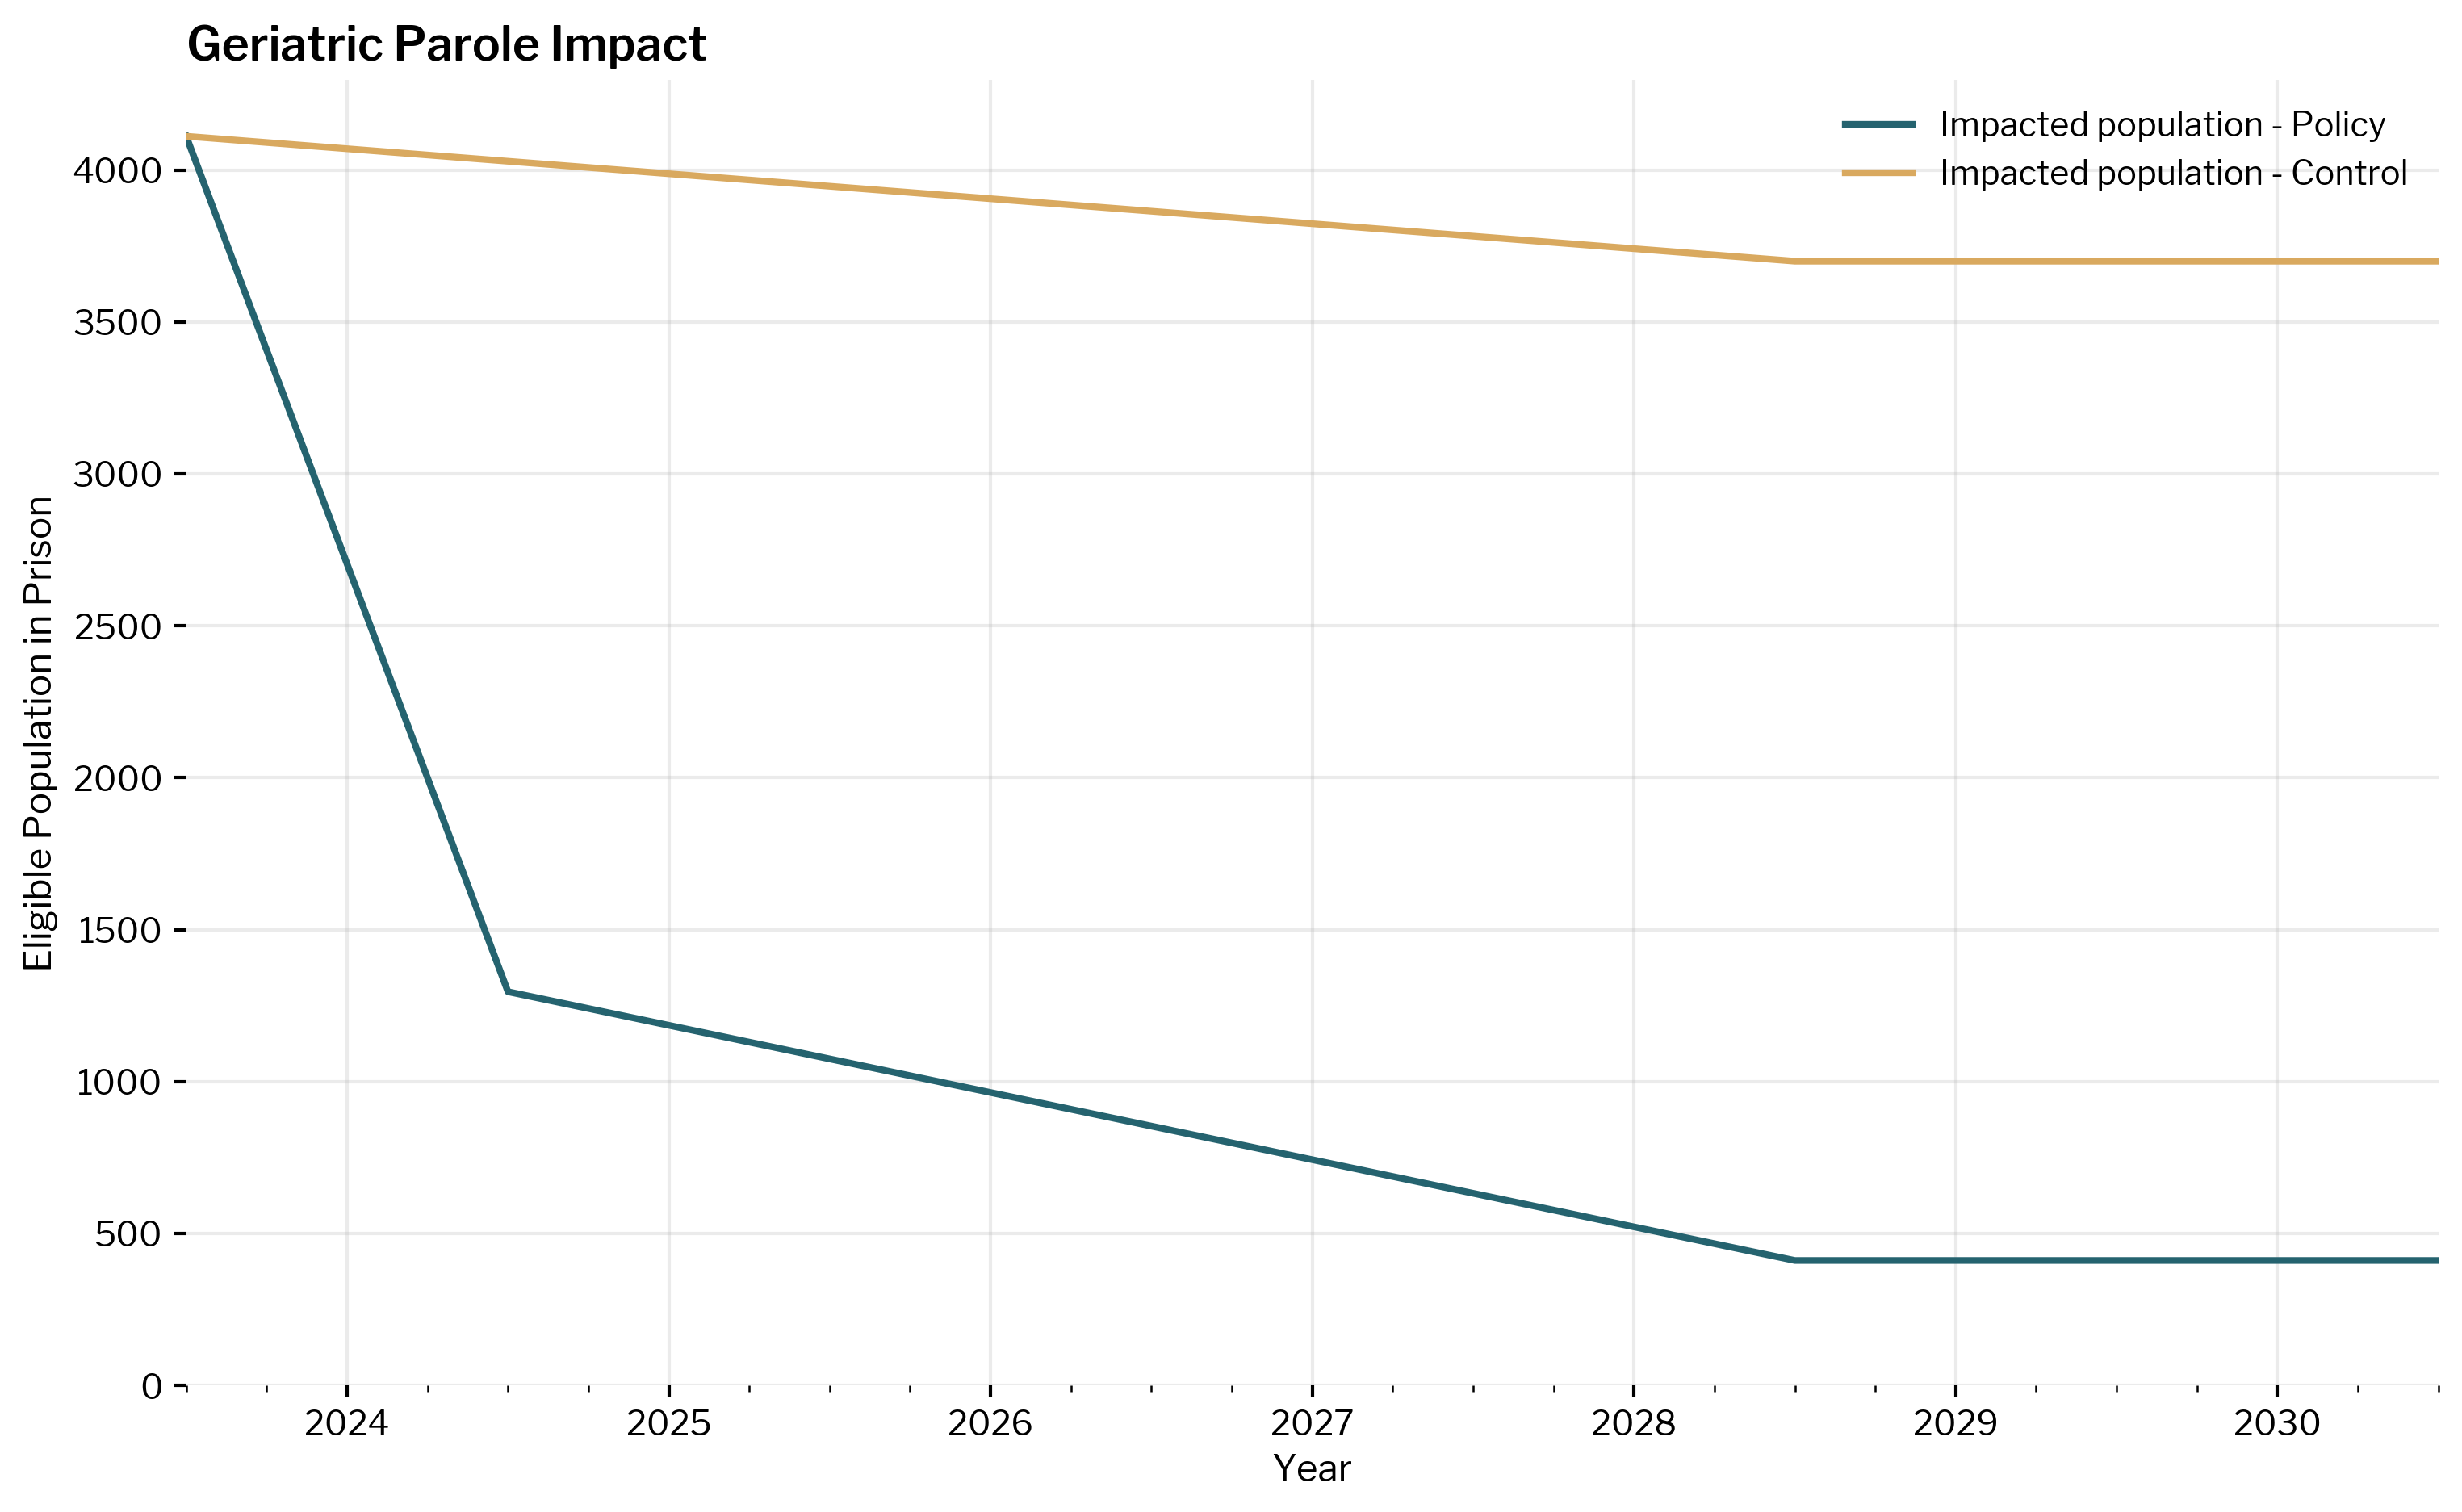

In [331]:
impact.set_index("date")[["geriatric_total", "control_total"]].rename(
    columns={
        "geriatric_total": "Impacted population - Policy",
        "control_total": "Impacted population - Control",
    }
).plot()
plt.ylim(0)
plt.ylabel("Eligible Population in Prison")
plt.xlabel("Year")
plt.xlim(pd.to_datetime("2023-07-01"), pd.to_datetime("2030-07-01"))
plt.title("Geriatric Parole Impact");

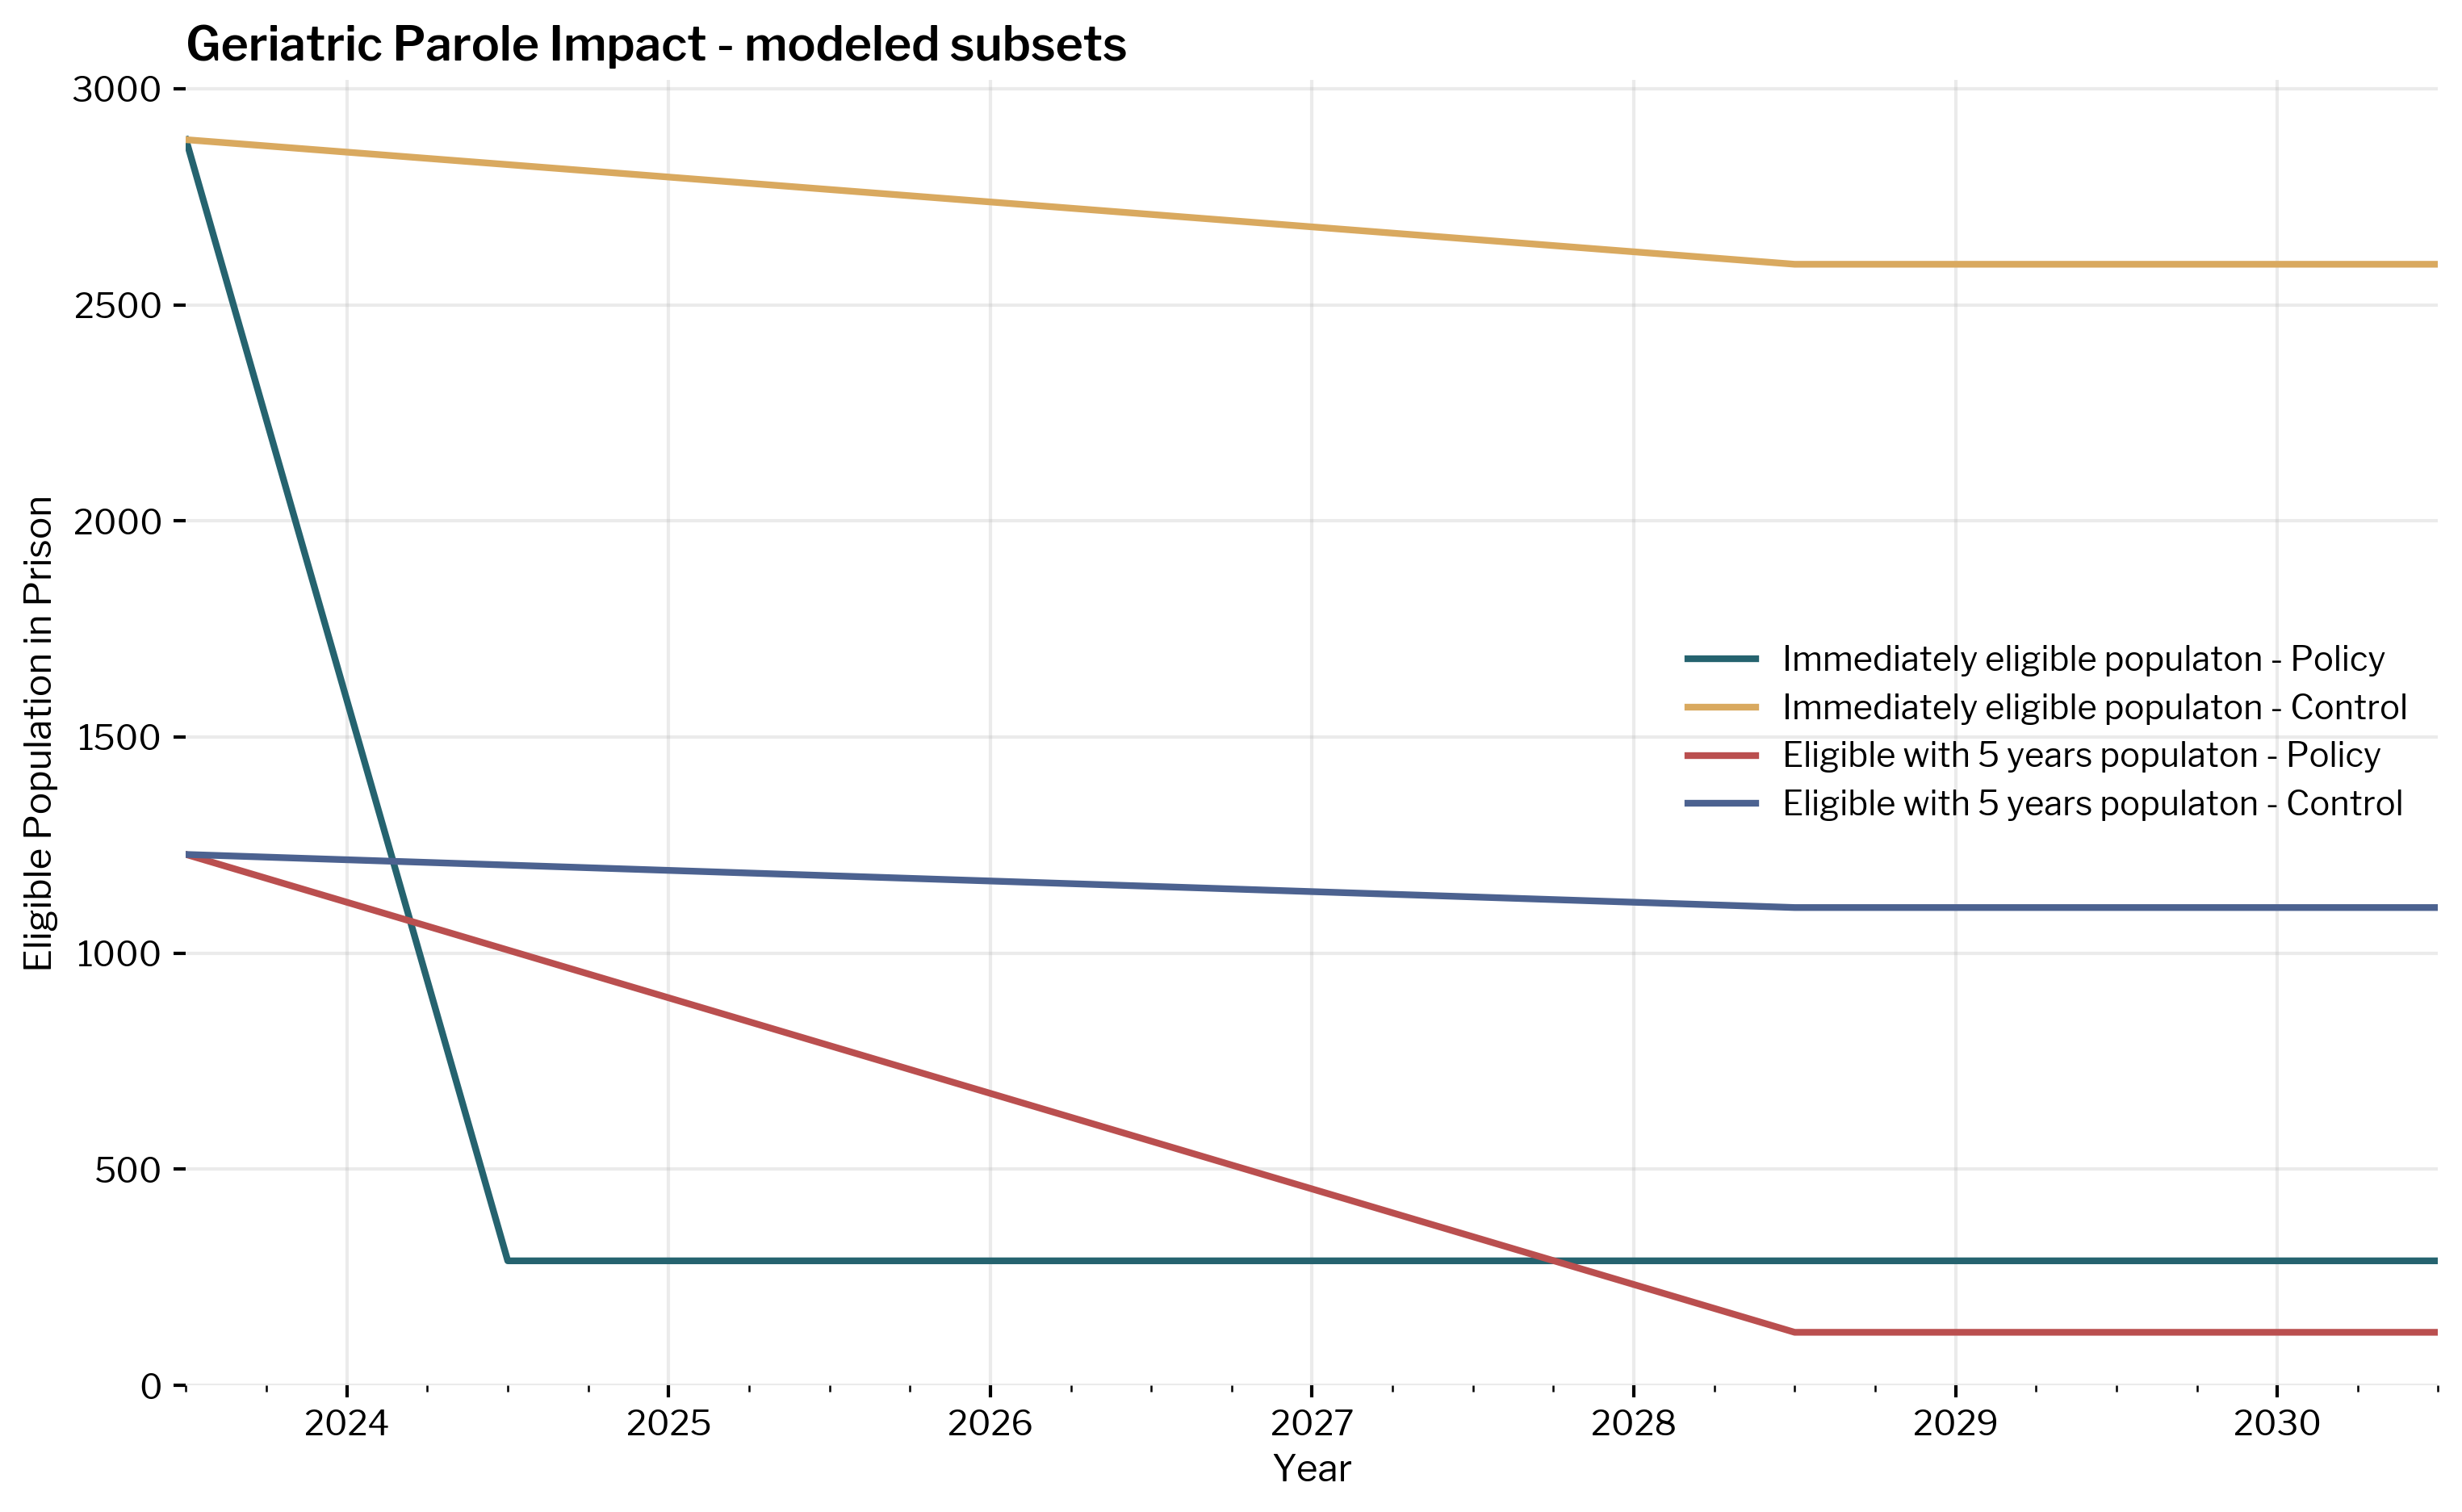

In [332]:
(
    impact.set_index("date")[
        ["geriatric", "control", "geriatric_within_five", "control_within_five"]
    ].rename(
        columns={
            "geriatric": "Immediately eligible populaton - Policy",
            "control": "Immediately eligible populaton - Control",
            "geriatric_within_five": "Eligible with 5 years populaton - Policy",
            "control_within_five": "Eligible with 5 years populaton - Control",
        }
    )
).plot()
plt.ylim(0)
plt.ylabel("Eligible Population in Prison")
plt.xlabel("Year")
plt.xlim(pd.to_datetime("2023-07-01"), pd.to_datetime("2030-07-01"))
plt.title("Geriatric Parole Impact - modeled subsets");

In [333]:
# FY2022 parole grant rate for ages 50+
# which is equal to general grant rate
(82 + 26 + 2) / (753 + 310 + 57) * 100

9.821428571428571